In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

import pandas as pd

In [ ]:
filename = "ASASSN-16cs.dat"

df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
df = df.dropna()
df.head()

,MJD,FLT,FLUXCAL,FLUXCALERR,MAG,MAGERR
0,57459.23554,g,37214.832,567.712,16.073,0.017
1,57467.23967,g,41744.556,650.066,15.949,0.017
2,57475.26347,g,28919.307,447.921,16.347,0.017
3,57483.24414,g,16594.694,286.561,16.950,0.019
4,57495.24593,g,5925.251,190.618,18.068,0.035


In [ ]:
tmax = 57464.23 if filename=="ASASSN-16cs.dat" else 57442.92
z_helio = 0.01802 if filename=="ASASSN-16cs.dat" else 0.06741

g_time = (df.MJD[df.FLT=='g'] - tmax) / (1 + z_helio)
r_time = (df.MJD[df.FLT=='r'] - tmax) / (1 + z_helio)
i_time = (df.MJD[df.FLT=='i'] - tmax) / (1 + z_helio)
z_time = (df.MJD[df.FLT=='z'] - tmax) / (1 + z_helio)

g_mag = df.MAG[df.FLT=='g']
r_mag = df.MAG[df.FLT=='r']
i_mag = df.MAG[df.FLT=='i']
z_mag = df.MAG[df.FLT=='z']

g_magerr = df.MAGERR[df.FLT=='g']
r_magerr = df.MAGERR[df.FLT=='r']
i_magerr = df.MAGERR[df.FLT=='i'][:-1]
z_magerr = df.MAGERR[df.FLT=='z']



i_mag = i_mag[:-1]
i_time = i_time[:-1] ## remove last point which is outside the (-10, 40) time range

In [ ]:
z_mag

22    16.411
23    16.457
24    16.776
25    16.831
26    16.871
27    17.268
Name: MAG, dtype: float64

In [ ]:
z_time

22    -4.904933
23     2.957496
24    10.839276
25    18.678680
26    30.468016
27    37.345091
Name: MJD, dtype: float64

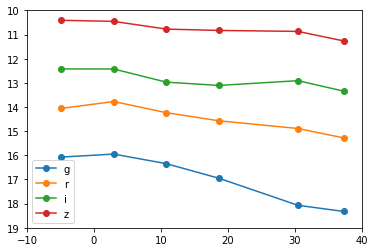

In [ ]:
plt.plot(g_time, g_mag, label='g', marker='o')
plt.plot(r_time, r_mag-2, label = 'r', marker='o')
plt.plot(i_time, i_mag-4,label = 'i', marker='o')
plt.plot(z_time, z_mag-6, label = 'z', marker='o')
plt.legend()
plt.ylim(19,10)
plt.xlim(-10, 40)
plt.show() ## replicating Stephen's figure (Figure 11 in Foundation DR1 with BayeSN)

In [ ]:
def fit_gp(time, mag, magerr, numsamples = 20):

  ## copied from https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP
  def build_gp(amplitude, length_scale):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=np.expand_dims(time.values, 1),
        observation_noise_variance=magerr.values[0]
        )

  gp_joint_model = tfd.JointDistributionNamed({
      'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
      'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
      'observations': build_gp,
  })

  constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

  amplitude_var = tfp.util.TransformedVariable(
      initial_value=8.,
      bijector=constrain_positive,
      name='amplitude',
      dtype=np.float64)

  length_scale_var = tfp.util.TransformedVariable(
      initial_value=30.,
      bijector=constrain_positive,
      name='length_scale',
      dtype=np.float64)

  trainable_variables = [v.trainable_variables[0] for v in 
                        [amplitude_var,
                        length_scale_var]]

  def target_log_prob(amplitude, length_scale):
    return gp_joint_model.log_prob({
        'amplitude': amplitude,
        'length_scale': length_scale,
        'observation_noise_variance':magerr.values[0],
        'observations': mag.values,
    })

  # Now we optimize the model parameters.
  num_iters = 1000
  optimizer = tf.optimizers.Adam(learning_rate=.01)

  # Use `tf.function` to trace the loss for more efficient evaluation.
  @tf.function(autograph=False, jit_compile=False)
  def train_model():
    with tf.GradientTape() as tape:
      loss = -target_log_prob(amplitude_var, length_scale_var)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

  # Store the likelihood values during training, so we can plot the progress
  lls_ = np.zeros(num_iters, np.float64)
  for i in range(num_iters):
    loss = train_model()
    # print(loss)
    lls_[i] = np.mean(loss.numpy())

  print('Trained parameters:')
  print('amplitude: {}'.format(amplitude_var._value().numpy()))
  print('length_scale: {}'.format(length_scale_var._value().numpy()))

  # plt.figure(figsize=(12, 4))
  # plt.plot(lls_)
  # plt.xlabel("Training iteration")
  # plt.ylabel("Log marginal likelihood")
  # plt.show()

  optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var._value().numpy(), length_scale_var._value().numpy())

  posterior = tfp.distributions.GaussianProcessRegressionModel(kernel = optimized_kernel,
                                                             index_points=np.linspace(-10., 40., 100)[..., np.newaxis],
                                                             observation_index_points=np.expand_dims(time.values, 1),
                                                             observations=mag.values,
                                                             observation_noise_variance = magerr.values[0],
                                                             predictive_noise_variance=0.)
  
  samples = posterior.sample(numsamples).numpy()
  return samples

In [ ]:
num_samples = 20
g_samples = fit_gp(g_time, g_mag, g_magerr, num_samples)

Trained parameters:
amplitude: 8.628032236389942
length_scale: 33.57186118678442


In [ ]:
np.shape(g_samples)

(20, 100)

In [ ]:
i_samples = fit_gp(i_time, i_mag, i_magerr, num_samples)

Trained parameters:
amplitude: 9.53163291189278
length_scale: 21.12927313330579


In [ ]:
z_samples = fit_gp(z_time, z_mag, z_magerr, num_samples)
r_samples = fit_gp(r_time, r_mag, r_magerr, num_samples)

Trained parameters:
amplitude: 8.29268436396079
length_scale: 45.653068218515095
Trained parameters:
amplitude: 8.49236076830283
length_scale: 43.260206033975294


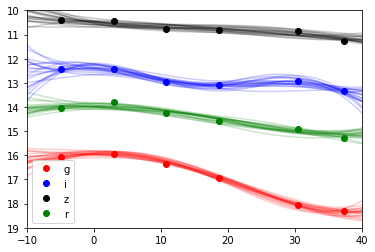

In [ ]:
for i in range(num_samples):
  plt.plot(np.linspace(-10., 40., 100), g_samples[i], 'r', alpha = 0.2)
  plt.plot(np.linspace(-10., 40., 100), i_samples[i]-4, 'b', alpha = 0.2)
  plt.plot(np.linspace(-10., 40., 100), z_samples[i]-6, 'k', alpha = 0.2)
  plt.plot(np.linspace(-10., 40., 100), r_samples[i]-2, 'g', alpha = 0.2)


plt.plot(g_time, g_mag, 'ro', label = 'g')
plt.plot(i_time, i_mag-4, 'bo', label =  'i')
plt.plot(z_time, z_mag-6, 'ko', label ='z')
plt.plot(r_time, r_mag-2, 'go', label = 'r')

# plt.plot(g_time, g_mag, label='g', marker='o')
# plt.plot(r_time, r_mag-2, label = 'r', marker='o')
# plt.plot(i_time, i_mag-4,label = 'i', marker='o')
# plt.plot(z_time, z_mag-6, label = 'z', marker='o')
plt.legend()
plt.ylim(19,10)
plt.xlim(-10, 40)
plt.show() 

In [ ]:
## copied from https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP
def build_gp(amplitude, length_scale):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=np.expand_dims(g_time.values, 1),
      observation_noise_variance=g_magerr.values[0]
      )

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

def target_log_prob(amplitude, length_scale):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance':g_magerr.values[0],
      'observations': g_mag.values,
  })

In [ ]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [8., 30.]]


In [ ]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

samples, kernel_results = do_sampling()


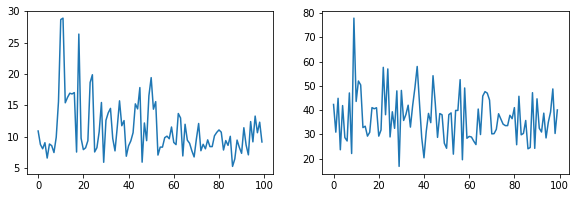

In [ ]:
(amplitude_samples,
 length_scale_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
  ax = f.add_subplot(1, len(samples) + 1, i + 1)
  ax.plot(s)


In [ ]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale_samples)

predictive_index_points = np.linspace(-10., 40., 100)[..., np.newaxis]
observation_index_points = np.expand_dims(g_time.values, 1)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points,
    observation_index_points=observation_index_points,
    observations=g_mag.values,
    observation_noise_variance=g_magerr.values[0],
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 20
samples = predictive_gprm.sample(num_samples)


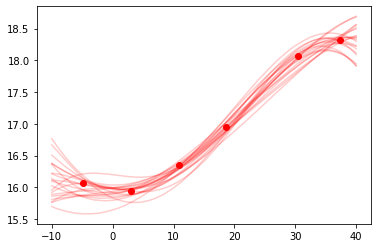

In [ ]:
for i in range(num_samples):
  plt.plot(predictive_index_points, samples[i,:],'r', alpha=0.2)

plt.plot(g_time, g_mag, 'ro')